In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Sentiment Analysis - US Airline industry

The goal of this project is to analyse the user sentiment towards the US airline industry on twitter using different models from the scikit-learn library.
- the dataset used contains a manually labelled sentiment per tweet : (positive, negative, neutral)

### Loading the libraries needed:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import math
import time
from collections import Counter
from scipy.stats import sem, t
#nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
#sklearn
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
#models
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

### Loading and inspecting the dataset

In [3]:
df = pd.read_table('dataset_airlines.tsv', usecols=[0,1,2], names=['instance_num', 'tweet', 'sentiment'], header=None)
df.head()
print('')
#checking the data, checking for Missing Values and the type of data
df.info(verbose=True)

,instance_num,tweet,sentiment
0,1,@JetBlue thank you for incredible customer svc...,positive
1,2,"@united I was well taken care of, thanks. I've...",positive
2,3,"@united Too Late Flight, damage has been done....",negative
3,4,"@USAirways of course! ""Yeah, travel has gotten...",negative
4,5,@united I'm very frustrated and have wasted 2 ...,negative



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   instance_num  4000 non-null   int64 
 1   tweet         4000 non-null   object
 2   sentiment     4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


[Text(0.5, 1.0, 'Count by sentiment')]

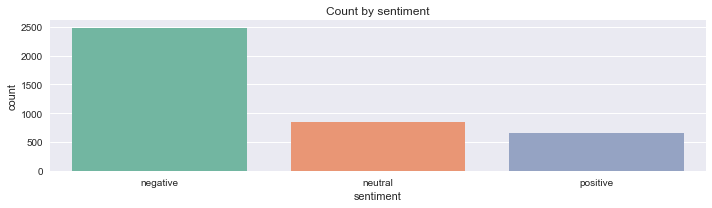

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
sns.countplot(df['sentiment'], palette="Set2",order = df['sentiment'].value_counts().index, ax=ax).set(title= f'Count by sentiment')
plt.tight_layout()
plt.show()

## Cleaning the tweets.
The tweets must be cleaned due to the special characters. Only strings and the characters: @, # would be mantained in the original tweets. Also we are going to consider the common words in english by using the stop words from nltk

In [5]:
#cleaning the tweets. removing special characters, etc
def clean_tweet(tweet, stop_words=False):
    tweet_cleaned = [''.join(re.findall('[a-zA-Z\@#]',word)).lower() for word in tweet.split()]
    
    if '' in tweet_cleaned:
        tweet_cleaned.remove('')
        
    if stop_words == True:
        tweet_cleaned = [word for word in tweet_cleaned if (len(word) > 1 and word not in stop_words_english)]
    
    if stop_words == False:
        tweet_cleaned = [word for word in tweet_cleaned if (len(word) > 1)]
        
    return tweet_cleaned         

In [6]:
df_2 = df.copy()
#nltk.download('stopwords')
stop_words_english = set(stopwords.words('english')) #for getting the most common words in english
negative_words = {word for word in stop_words_english if word[-2:] == "'t"} #negative words
negative_words.add('no')
negative_words.add('not')
negative_words.add('nor')

stop_words_english = stop_words_english.difference(negative_words) #dont want to remove the negative words for sentiments
stop_words_english.add('im') #Adding im to the set


In [7]:
df_2['tweet'] = df_2['tweet'].apply(lambda tweet: clean_tweet(tweet, stop_words=True))
df_2.head()

,instance_num,tweet,sentiment
0,1,"[@jetblue, thank, incredible, customer, svc, g...",positive
1,2,"[@united, well, taken, care, thanks, ive, alre...",positive
2,3,"[@united, late, flight, damage, done, easily, ...",negative
3,4,"[@usairways, course, yeah, travel, gotten, har...",negative
4,5,"[@united, frustrated, wasted, days, due, equip...",negative


## Data Exploration

First we are going to explore if exists a relation between the airlines and the sentiment

In [8]:
df_2['tweeter_users'] = df_2['tweet'].apply(lambda tweet: [word for word in tweet if '@' in word])

Getting the airlines present in the dataset

In [9]:
total_tweeter_users = []
for user in df_2['tweeter_users']: #merging all the tweets in 1 list separated by word
    total_tweeter_users.extend(user)
        
count_users = Counter(total_tweeter_users)
top_10 = count_users.most_common()[:10]
top_10

[('@united', 1079),
 ('@americanair', 847),
 ('@usairways', 781),
 ('@southwestair', 674),
 ('@jetblue', 590),
 ('@virginamerica', 140),
 ('@imaginedragons', 19),
 ('@delta', 18),
 ('@jetblues', 9),
 ('@wsj', 8)]

We can see that the most relevant airlines in the dataset are: **united**, **americanair**, **usairways**, **southwestair**, **jetblue** and **virginamerica**

In [10]:
airlines_dataset = {airline[0] for airline in top_10[:6]}

In [11]:
def get_airlines(tweet_user):
    users = [user for user in tweet_user if user in airlines_dataset]
    airlines = np.unique(users)
    return airlines

In [12]:
df_2['airlines'] = df_2['tweeter_users'].apply(lambda tweeter_user: get_airlines(tweeter_user))
df_2.drop(columns=['tweeter_users'], inplace=True)
df_2.drop(columns=['instance_num'], inplace=True)

In [13]:
sentiments = np.unique(df_2['sentiment'])
dict_sentiments = {}
for sentiment in sentiments:
    df_aux = df_2[df_2['sentiment'] == sentiment]
    
    total = []
    for t in df_aux['airlines']: #merging all the tweets in 1 list separated by word
        total.extend(t)
        c = Counter(total)
        dict_sentiments[sentiment] = c 

[Text(0.5, 1.0, 'Count of tweets for Southwestair')]

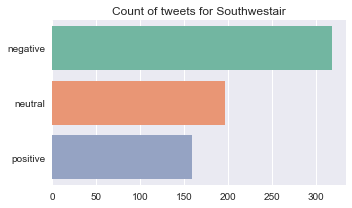

[Text(0.5, 1.0, 'Count of tweets for Usairways')]

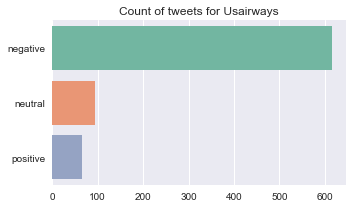

[Text(0.5, 1.0, 'Count of tweets for Americanair')]

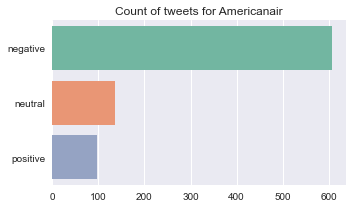

[Text(0.5, 1.0, 'Count of tweets for Jetblue')]

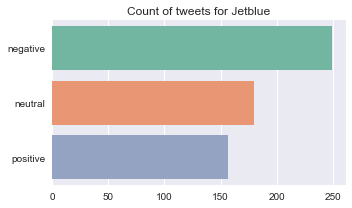

[Text(0.5, 1.0, 'Count of tweets for Virginamerica')]

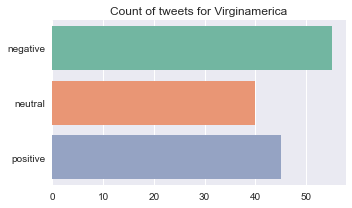

[Text(0.5, 1.0, 'Count of tweets for United')]

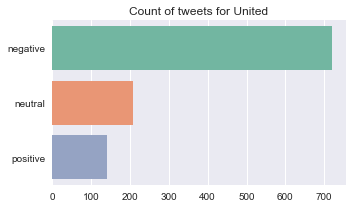

In [14]:
for airline in airlines_dataset:
    
    count_sentiments = {}
    for sentiment in sentiments:
        count_sentiments[sentiment] = dict_sentiments[sentiment][airline]
    
    airline = airline.replace('@','').capitalize()
    
    fig, ax = plt.subplots(1,1, figsize=(5, 3))   
    sns.barplot(y=list(count_sentiments.keys()), x =list(count_sentiments.values()),palette='Set2')\
    .set(title= f'Count of tweets for {airline}')
    
    plt.tight_layout()
    plt.show()

Possible to observe that when a tweet containts the airlines twitter page it may affect the sentiment of the tweet, hence, we are not going to remove them for training the models.

### Common words (without filtering by sentiment and removing the @airlines from the tweets)

In [15]:
def plot_most_common(df,sentiment,key,top=10):
    assert key in {'words', 'airlines'}
    
    if key == 'words':
        aux = 'tweet'
        
    if key == 'airlines':
        aux = key
    
    total = []
    for t in df[aux]: #merging all the tweets in 1 list separated by word
        total.extend(t)

    c = Counter(total)
    top_values = np.array(c.most_common()[:top])
    #plot
    count_to_int = list(map(lambda count: int(count), top_values[:,1]))

    fig, ax = plt.subplots(1,1, figsize=(11, 4))
    if key == 'words':
        aux2 = f'(Top {top})'
    
    elif key == 'airlines':
        aux2 = ''
    
    sns.barplot(x=top_values[:,0], y=count_to_int, palette='Set2')\
                .set(title= f'Most common {key} in the dataset {aux2} for the sentiment: {sentiment.capitalize()}')
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('count') 
    plt.tight_layout()
    plt.show()

In [16]:
df_2['tweet'] = df_2['tweet'].apply(lambda tweet: [word for word in tweet if word not in airlines_dataset])

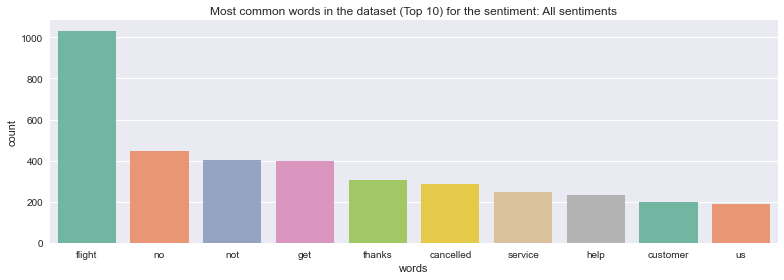

In [17]:
plot_most_common(df_2,sentiment='all sentiments', key='words', top=10)

### Common words: Filtering by sentiment

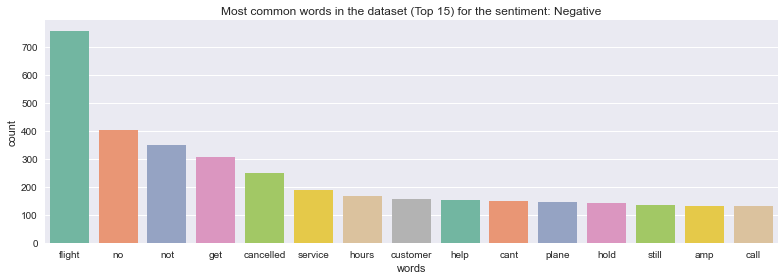

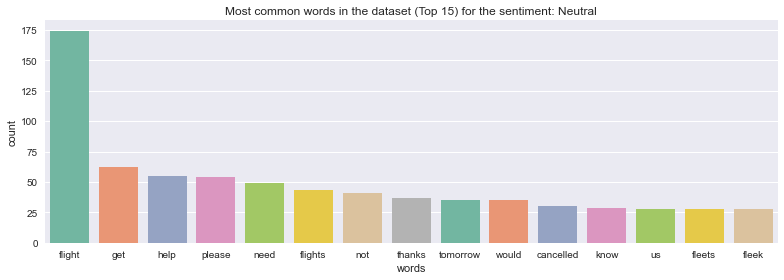

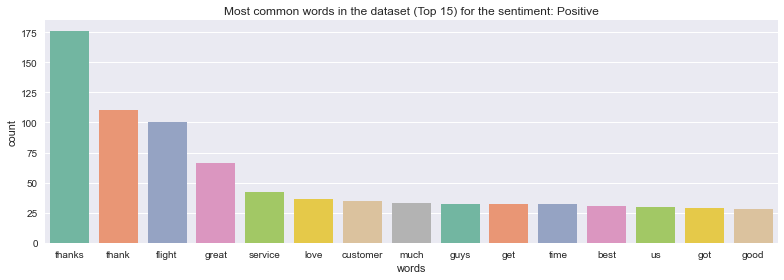

In [18]:
#most common words, filtering by sentiment
sentiments = np.unique(df_2['sentiment'].values)
for sentiment in sentiments:
    df_aux = df_2[df_2['sentiment'] == sentiment]
    plot_most_common(df_aux,sentiment,key='words', top=15)

## Preprocessing: lemmatization and stemming
Lemmatisation and stemming is going to be applied as preprocessing. 2 different datasets are going to be created in order to have more options for training the different models

### Applying lemmatization
Lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. <br>
More info [Wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

In [19]:
df_lemma = df_2.copy()

def lemmatization(tweet):
    lemma = WordNetLemmatizer()
    normalized_sentence = []
    for word in tweet:
        normalized_sentence.append(lemma.lemmatize(word))
        
    return normalized_sentence

In [20]:
df_lemma['tweet'] = df_lemma.apply(lambda row: lemmatization(row['tweet']), axis=1)

### Applying stemming
Stemming is the process of producing morphological variants of a root/base word. <br>
More info [GeeksforGeeks](https://www.geeksforgeeks.org/introduction-to-stemming/)


In [21]:
df_stemm = df_2.copy()

def stemming(tweet):
    porter = PorterStemmer()
    normalized_sentence = []
    for word in tweet:
        normalized_sentence.append(porter.stem(word))
        
    return normalized_sentence

In [22]:
df_stemm['tweet'] = df_stemm.apply(lambda row: stemming(row['tweet']), axis=1)

## Preprocessing: formating the tweets back to phrases

First, the @airlines are going to be added back to the tweets. It is important to note that because CountVectorizer is going to be used before training the models, the order of the words for each tweet does not matter.

In [23]:
def join_words(tweet, airline):
    tweet.extend(airline)
    join_words = ' '.join([str(word) for word in tweet])
    return join_words

In [24]:
df_2['tweet'] = df_2.apply(lambda row: join_words(row['tweet'], row['airlines']), axis=1)
df_lemma['tweet'] = df_lemma.apply(lambda row: join_words(row['tweet'], row['airlines']), axis=1)
df_stemm['tweet'] = df_stemm.apply(lambda row: join_words(row['tweet'], row['airlines']), axis=1)

In [25]:
#example
print(df.iloc[11,1]) #no preprocessing
print(df_2.iloc[11,0]) #removing stop words
print(df_lemma.iloc[11,0]) #removing stop words + lemma
print(df_stemm.iloc[11,0]) #removing stop words + stemm

@SouthwestAir You need to be more accommodating to your loyal customers. Not happy now!
need accommodating loyal customers not happy @southwestair
need accommodating loyal customer not happy @southwestair
need accommod loyal custom not happi @southwestair


## Splitting the dataset into a training and test set

In [26]:
def train_test_split_df(df, seed):
    X = df['tweet'].to_list()
    y = df['sentiment'].to_list()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
    return X_train, X_test, y_train, y_test    

In [27]:
df_lists = [df_2, df_lemma, df_stemm]

X_train_list =[]
X_test_list = []
y_train_list = []
y_test_list = []

for df in df_lists:
    X_train, X_test, y_train, y_test = train_test_split_df(df, 111)
    
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

print(f'The training size is: {len(X_train_list[0])} tweets')
print(f'The test size is: {len(X_test_list[0])} tweets')

The training size is: 3200 tweets
The test size is: 800 tweets


### Vectorizing the tweets.
The sentences of each tweet are transformed into a vector that contains the frequence of each word of the tweet present in the tweet (bags of words) from the vocabulary

In [28]:
def vectorize_dataset(X_train,X_test, max_features):
    
    vectorize = CountVectorizer(max_features=max_features)
    vectorizer_train = vectorize.fit_transform(X_train)
    vectorizer_test = vectorize.transform(X_test)
    
    vocabulary = vectorize.get_feature_names()
      
    return vectorizer_train, vectorizer_test, vocabulary

In [29]:
X_train_list_vect =[] #a list to save the differents df: only with stop words, stop words+lemma, stop words+stemm
X_test_list_vect = []
vocabulary_vect = []

for i in range(3):
    vectorizer_train, vectorizer_test, vocabulary = vectorize_dataset(X_train_list[i], X_test_list[i],1500)
    X_train_list_vect.append(vectorizer_train)
    X_test_list_vect.append(vectorizer_test)
    vocabulary_vect.append(vocabulary)

## Training different models

### Cross Validation
Models that are going to be tested with the default parameters: **Decision Tree**, **Multinomial Naive Bayes**, **Complement Naive Bayes**, **SVM**, **Random Forest** <br>
5 cross validations are going to be made for each model.

In [30]:
models = [DecisionTreeClassifier(), MultinomialNB(), ComplementNB(),\
          LinearSVC(), RandomForestClassifier()]

models_name = ['DT', 'MNB', 'CNB','SVM', 'RF']

In [31]:
from scipy.stats import sem, t

def models_comparison(models_name,df_scores):
    confidence = 0.95
    models_resume = []
    for name, mean, std in zip(models_name,df_scores.mean(),df_scores.std()):
        dict_model = {}
        n = len(df_scores)
        h = std * t.ppf((1 + confidence) / 2, n - 1)
        interval =[round(mean+h,3),round(mean-h,3)]
        dict_model['Model'] = name
        dict_model['Accuracy'] = round(mean,3)
        dict_model['Std'] = round(std,3)
        dict_model['Confidence Interval'] = interval
        models_resume.append(dict_model)
        
    df_scores = pd.DataFrame(models_resume)
    df_scores = df_scores.set_index('Model').sort_values(by='Accuracy', ascending=False)
    return df_scores

### Only considering stop words

In [32]:
df_scores = pd.DataFrame()
for model_name, model in zip(models_name, models):
    scores = cross_val_score(model, X_train_list_vect[0], y_train_list[0], scoring = 'accuracy', cv=5)
    df_scores[model_name] = scores

In [33]:
models_comparison(models_name,df_scores)

,Accuracy,Std,Confidence Interval
Model,,,
MNB,0.746,0.007,"[0.765, 0.727]"
CNB,0.742,0.003,"[0.75, 0.735]"
RF,0.730,0.013,"[0.767, 0.693]"
SVM,0.728,0.013,"[0.765, 0.692]"
DT,0.637,0.016,"[0.682, 0.593]"


## Considering stop words + lemmatization

In [34]:
df_scores = pd.DataFrame()
for model_name, model in zip(models_name, models):
    scores = cross_val_score(model, X_train_list_vect[1], y_train_list[1], scoring = 'accuracy', cv=5)
    df_scores[model_name] = scores

In [35]:
models_comparison(models_name,df_scores)

,Accuracy,Std,Confidence Interval
Model,,,
MNB,0.750,0.012,"[0.783, 0.716]"
CNB,0.745,0.007,"[0.764, 0.727]"
SVM,0.728,0.013,"[0.764, 0.692]"
RF,0.728,0.012,"[0.761, 0.695]"
DT,0.652,0.015,"[0.695, 0.609]"


## Considering stop words + stemming

In [36]:
df_scores = pd.DataFrame()
for model_name, model in zip(models_name, models):
    scores = cross_val_score(model, X_train_list_vect[2], y_train_list[2], scoring = 'accuracy', cv=5)
    df_scores[model_name] = scores

In [37]:
models_comparison(models_name,df_scores)

,Accuracy,Std,Confidence Interval
Model,,,
MNB,0.752,0.010,"[0.78, 0.725]"
CNB,0.750,0.010,"[0.778, 0.721]"
SVM,0.738,0.009,"[0.764, 0.711]"
RF,0.738,0.011,"[0.768, 0.707]"
DT,0.647,0.014,"[0.686, 0.609]"


Based on the previous results we can see that the models perform similarly. The Naive Bayes models (MNB and CNB) perform the best, but the **MNB** model + using **Stemming** and a **vocabulary** of 1500 words is sligthly better than the **CNB**. <br>
One property of the **CNB** is that is particularly suited for imbalanced data sets. More info: [ScikitLearn Docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html?highlight=complement%20naive%20bayes#sklearn.naive_bayes.ComplementNB) <br>
In the dataset most of the tweets tend to have a negative sentiment (imbalanced dataset). Due to this, the model that is going to be tunned is the **Complement Naive Bayes** using **stemming** as preprocessing and a vocabulary of **1500** words.

## Hyperparameters tunning

In [38]:
X_train = X_train_list_vect[2]
y_train = y_train_list[2]
X_test = X_test_list_vect[2]
y_test = y_test_list[2]

### Base Model

In [39]:
model_base = ComplementNB()
model_base.fit(X_train,y_train)

ComplementNB()

In [40]:
def model_predict(model, X_test, y_test):
    
    predicted_y = model.predict(X_test)
    print(classification_report(y_test, predicted_y,zero_division=0))

In [41]:
model_predict(model_base, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86       495
     neutral       0.55      0.45      0.50       148
    positive       0.61      0.75      0.67       157

    accuracy                           0.76       800
   macro avg       0.68      0.68      0.68       800
weighted avg       0.76      0.76      0.75       800



## Tunning

In [42]:
start = time.process_time()
print('Searching..')
#evaluated hyperparameters
search_parameters = {'alpha'     : [10,5,2,1.0,0.5,0.1,0],\
                      'fit_prior'     : [True, False]
                    }
             
#grid search
grid = GridSearchCV(ComplementNB(), #for early stop
                    param_grid = search_parameters,
                    scoring    = 'accuracy',
                    cv = 5,
                    n_jobs = -1,
                    return_train_score = True)
#fit
grid.fit(X_train, y_train)

print(f'time taken for the search : {time.process_time() - start} secs')

Searching..


GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [10, 5, 2, 1.0, 0.5, 0.1, 0],
                         'fit_prior': [True, False]},
             return_train_score=True, scoring='accuracy')

time taken for the search : 0.484375 secs


In [43]:
results = pd.DataFrame(grid.cv_results_)
print(f'The best model is: {grid.best_estimator_} \n')
results[['rank_test_score','mean_train_score','mean_test_score','params']].sort_values(by='rank_test_score').head(5) #best 5 models

The best model is: ComplementNB(alpha=5) 



,rank_test_score,mean_train_score,mean_test_score,params
2,1,0.822656,0.755000,"{'alpha': 5, 'fit_prior': True}"
3,1,0.822656,0.755000,"{'alpha': 5, 'fit_prior': False}"
4,3,0.845703,0.750312,"{'alpha': 2, 'fit_prior': True}"
5,3,0.845703,0.750312,"{'alpha': 2, 'fit_prior': False}"
6,5,0.852500,0.749687,"{'alpha': 1.0, 'fit_prior': True}"


# Best Model Test
The best model after performing the grid search is the  **ComplementNB(alpha=5)**

In [44]:
model_tunned = grid.best_estimator_

In [45]:
model_predict(model_tunned, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.81      0.90      0.85       495
     neutral       0.59      0.36      0.45       148
    positive       0.68      0.68      0.68       157

    accuracy                           0.76       800
   macro avg       0.69      0.65      0.66       800
weighted avg       0.74      0.76      0.74       800



## Confusion matrix

<AxesSubplot:>

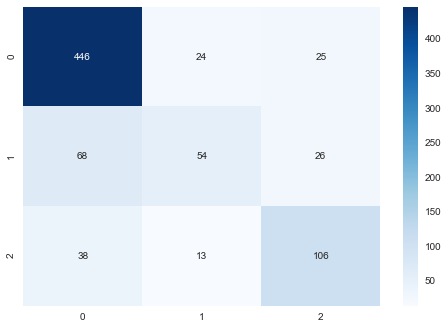

In [46]:
predicted_y = model_tunned.predict(X_test)
cm = confusion_matrix(y_test, predicted_y)

sns.heatmap(cm, annot=True, 
            fmt='g', cmap="Blues")